In [30]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Redefine stock tickers and date range
us_ticker = 'BABA'
hk_ticker = '9988.HK'
start_date = '2018-01-01'
end_date = '2024-11-5'
period = '5y'
interval = '1d'

# Fetch historical data again
us_data = yf.download(us_ticker, period=period, interval=interval)
hk_data = yf.download(hk_ticker, period=period, interval=interval)

# Additional features (VIX, SP500, HSI)
vix = yf.download('^VIX', start=start_date, end=end_date)['Close']
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close']
hsi = yf.download('^HSI', start=start_date, end=end_date)['Close']

# Combine the features into the DataFrame
df = pd.DataFrame(index=us_data.index)
df['US_Open'] = us_data['Open']
df['US_Close'] = us_data['Close']
df['HK_Close'] = hk_data['Close'] * 8 / 7.8
df['HK_Open_next'] = hk_data['Open'].shift(-1) * 8 / 7.8
df['VIX'] = vix
df['SP500'] = sp500
df['HSI'] = hsi

# Adding Volume Data for both US and HK
df['US_Volume'] = us_data['Volume']
df['HK_Volume'] = hk_data['Volume']

# Adding US 10-Year Treasury Yield and Forward Fill Missing Data
treasury_yield = yf.download('^TNX', start=start_date, end=end_date)['Close']
df['Treasury_Yield'] = treasury_yield

# Adding Moving Averages (20-day) for both US and HK
df['US_MA20'] = df['US_Close'].rolling(window=20).mean()
df['HK_MA20'] = df['HK_Close'].rolling(window=20).mean()

# Adding Relative Strength Index (RSI) for US Close Prices
def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['RSI_US'] = calculate_rsi(df['US_Close'])

# Adding Price Ratio (US to HK Close Prices)
df['US_HK_Ratio'] = df['US_Close'] / df['HK_Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### How does our dataset look with added features?

In [36]:
total_rows = df.shape[0]
print(total_rows)
df.head()

1259


,US_Open,US_Close,HK_Close,HK_Open_next,VIX,SP500,HSI,US_Volume,HK_Volume,Treasury_Yield,US_MA20,HK_MA20,RSI_US,US_HK_Ratio
Date,,,,,,,,,,,,,,
2019-11-05 00:00:00+00:00,181.419998,182.000000,NaN,NaN,13.10,3074.620117,27683.400391,23690200,NaN,1.866,NaN,NaN,NaN,NaN
2019-11-06 00:00:00+00:00,183.610001,184.160004,NaN,NaN,12.62,3076.780029,27688.640625,14834900,NaN,1.814,NaN,NaN,NaN,NaN
2019-11-07 00:00:00+00:00,187.070007,186.660004,NaN,NaN,12.73,3085.179932,27847.230469,20162600,NaN,1.926,NaN,NaN,NaN,NaN
2019-11-08 00:00:00+00:00,187.901993,187.160004,NaN,NaN,12.07,3093.080078,27651.140625,19718100,NaN,1.933,NaN,NaN,NaN,NaN
2019-11-11 00:00:00+00:00,184.820007,186.710007,NaN,NaN,12.69,3087.010010,26926.550781,20561500,NaN,1.943,NaN,NaN,NaN,NaN


### Since our dataset is missing certain values for holidays etc, we can plot a histogram and get a better overview of what values are missing

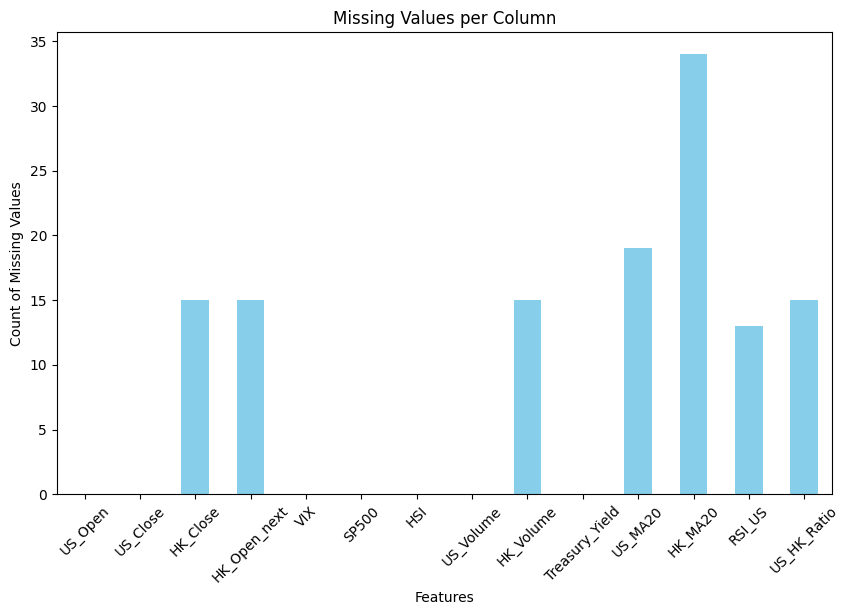

In [40]:
# Plotting missing values histogram
missing_values_count = df.isna().sum()
plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar', color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Features')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=45)
plt.show()

#### The values missing are likely due to holidays. Therefore, we fill in these values with the last known value they had.

In [45]:
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

### Plotting open/close prices for HK vs US

Correlation between US Opening price and HK Closing price: 0.9994685415730804
Correlation between US Closing price and HK Closing price: 0.9988383053132474
Correlation between US Closing price and HK Open price next day: 0.9995968608854829


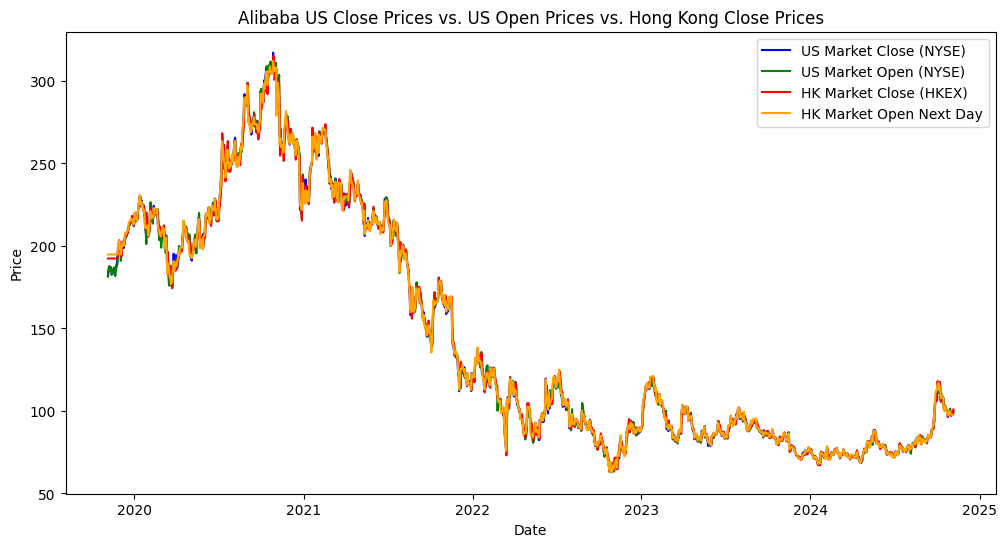

In [46]:
# Correlation calculations
correlation_1 = df['US_Open'].corr(df['HK_Close'])
correlation_2 = df['US_Close'].corr(df['HK_Close'])
correlation_3 = df['US_Close'].corr(df['HK_Open_next'])
print(f"Correlation between US Opening price and HK Closing price: {correlation_1}")
print(f"Correlation between US Closing price and HK Closing price: {correlation_2}")
print(f"Correlation between US Closing price and HK Open price next day: {correlation_3}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['US_Close'], label='US Market Close (NYSE)', color='blue')
plt.plot(df.index, df['US_Open'], label='US Market Open (NYSE)', color='green')
plt.plot(df.index, df['HK_Close'], label='HK Market Close (HKEX)', color='red')
plt.plot(df.index, df['HK_Open_next'], label='HK Market Open Next Day', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Alibaba US Close Prices vs. US Open Prices vs. Hong Kong Close Prices')
plt.legend()
plt.show()


### Machine learing using different regression methods:

Linear Regression - Mean Squared Error: 3.2612643871390166, R^2 Score: 0.9993231230737757
Decision Tree Regressor - Mean Squared Error: 6.591050834665934, R^2 Score: 0.9986320243623454
Random Forest Regressor - Mean Squared Error: 3.631339810079998, R^2 Score: 0.9992463137492268
Gradient Boosting Regressor - Mean Squared Error: 3.610788710551299, R^2 Score: 0.9992505791394032


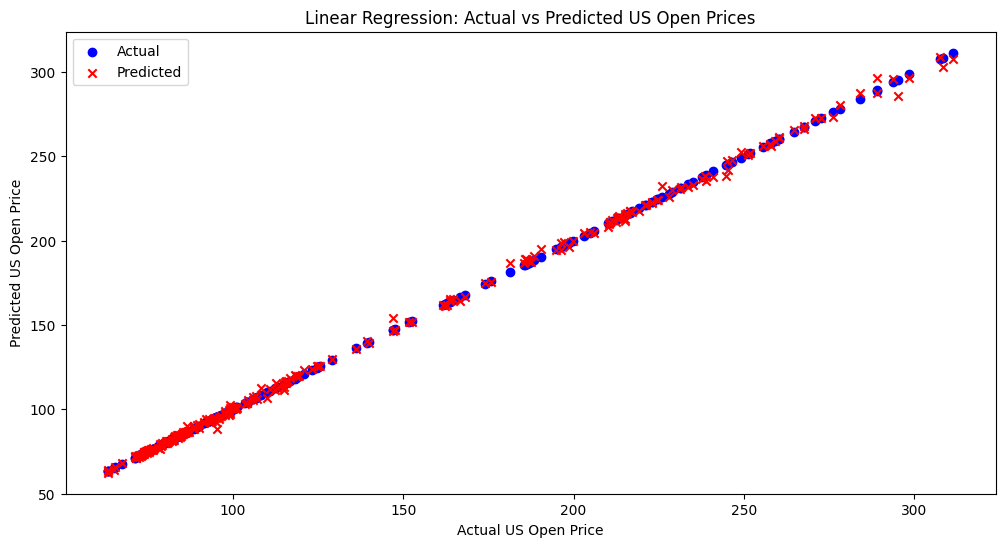

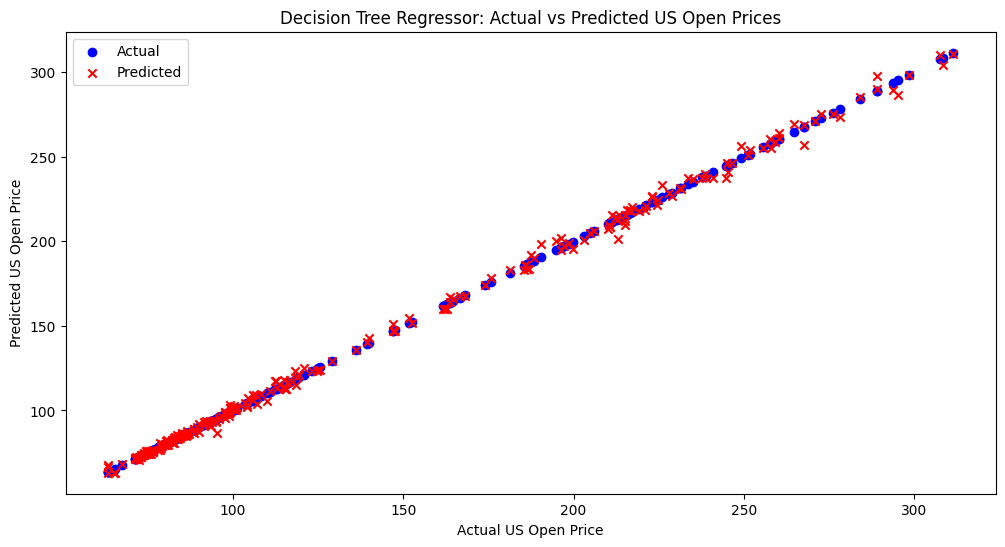

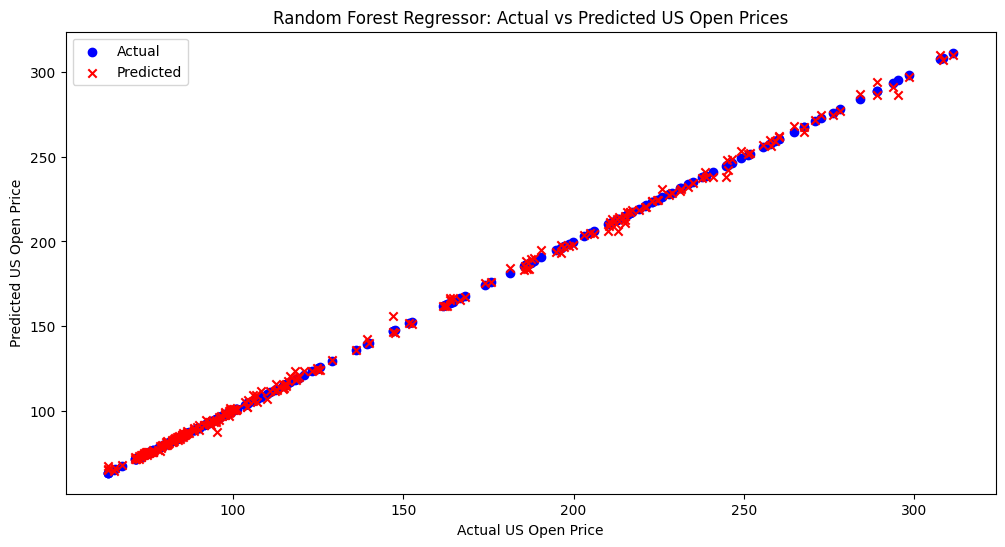

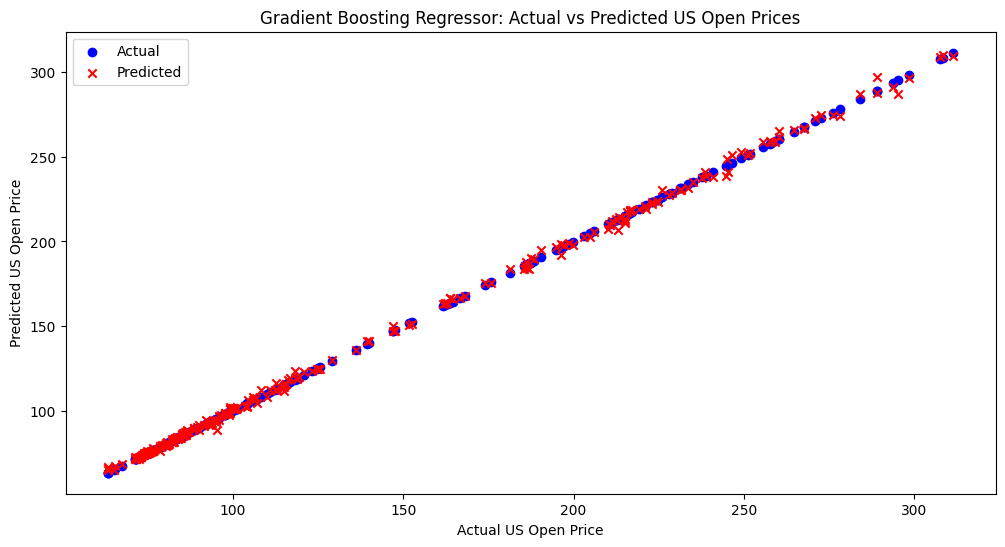

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score



# Machine Learning models to predict US Open Price based on multiple features
# Prepare the data
X = df[['HK_Close', 'US_Close', 'VIX', 'Treasury_Yield', 'RSI_US', 'US_HK_Ratio','US_Volume','HK_Volume', 'US_MA20','HK_MA20']]
y = df['US_Open']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - Mean Squared Error: {mse}, R^2 Score: {r2}")
    return y_pred

# Linear Regression
linear_model = LinearRegression()
y_pred_lr = evaluate_model(linear_model, X_train, X_test, y_train, y_test, "Linear Regression")

# Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=45)
y_pred_dt = evaluate_model(dt_model, X_train, X_test, y_train, y_test, "Decision Tree Regressor")

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=45)
y_pred_rf = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest Regressor")

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=45)
y_pred_gb = evaluate_model(gb_model, X_train, X_test, y_train, y_test, "Gradient Boosting Regressor")

# Plot actual vs predicted values for each model
models_predictions = {
    "Linear Regression": y_pred_lr,
    "Decision Tree Regressor": y_pred_dt,
    "Random Forest Regressor": y_pred_rf,
    "Gradient Boosting Regressor": y_pred_gb
}

for model_name, y_pred in models_predictions.items():
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_test, color='blue', label='Actual', marker='o')
    plt.scatter(y_test, y_pred, color='red', label='Predicted', marker='x')
    plt.xlabel('Actual US Open Price')
    plt.ylabel('Predicted US Open Price')
    plt.title(f"{model_name}: Actual vs Predicted US Open Prices")
    plt.legend()
    plt.show()


In [ ]:
#TO DO:
#Create LSTM model!
#Simulated Trading environment to test arbitrage results!


Correlation heatmaps for tech stocks US vs HK 

c:\Users\johan\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:814: UserWarning: Pandas requires version '2022.1' or newer of 'tzdata' (version '2021.5' currently installed).
  f_pre_midnight = (df.index.minute == 0) & (df.index.hour.isin([22, 23]))
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


Correlation matrix for US Tech Stocks:
Ticker      AAPL      AMZN     GOOGL      META      MSFT
Ticker                                                  
AAPL    1.000000  0.807265  0.839048  0.830296  0.832689
AMZN    0.807265  1.000000  0.959407  0.975645  0.978056
GOOGL   0.839048  0.959407  1.000000  0.929686  0.951240
META    0.830296  0.975645  0.929686  1.000000  0.963243
MSFT    0.832689  0.978056  0.951240  0.963243  1.000000


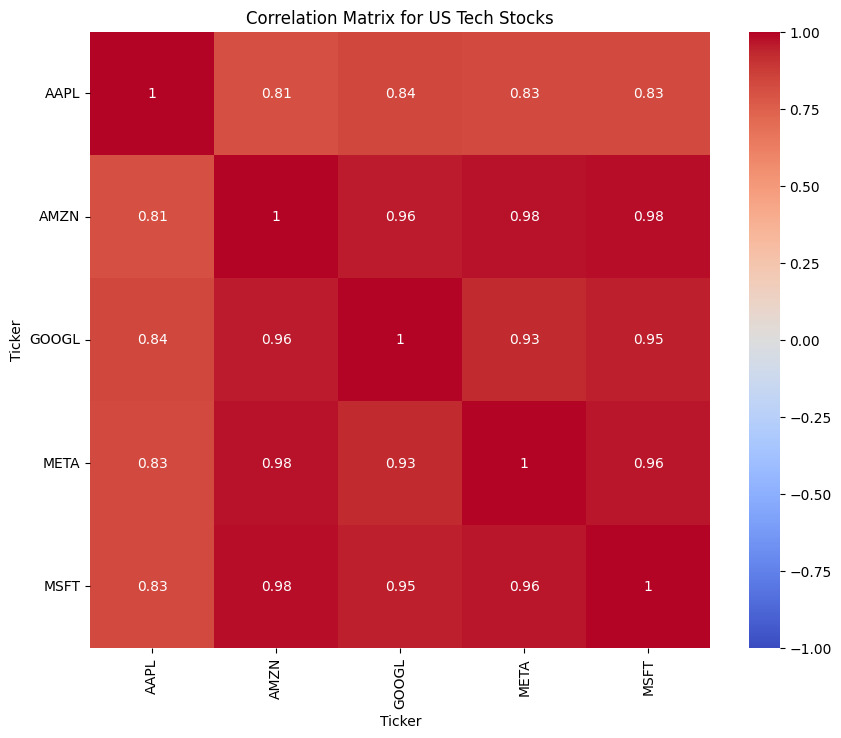


Correlation matrix for Chinese Tech Stocks:
Ticker    0700.HK   1810.HK      BABA      BIDU        JD
Ticker                                                   
0700.HK  1.000000  0.613471  0.601948  0.002687  0.211452
1810.HK  0.613471  1.000000  0.051952 -0.594867 -0.276174
BABA     0.601948  0.051952  1.000000  0.516944  0.702219
BIDU     0.002687 -0.594867  0.516944  1.000000  0.421643
JD       0.211452 -0.276174  0.702219  0.421643  1.000000


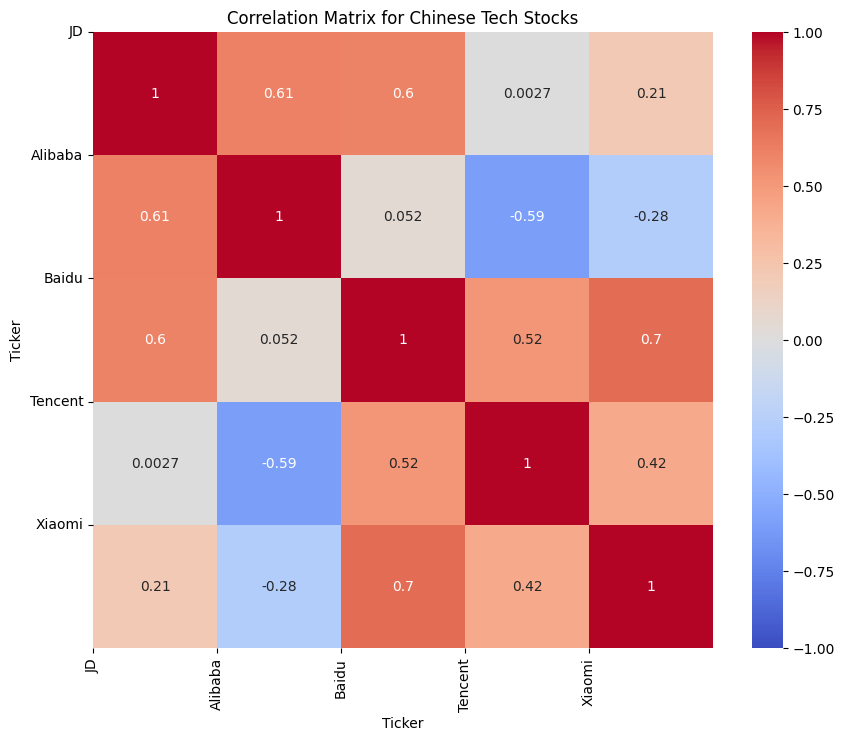

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define stock tickers for US tech stocks
us_tech_stocks = ["AAPL", "GOOGL", "AMZN", "META","MSFT"]

# Define stock tickers for Chinese tech stocks
china_tech_stocks = ["JD", "BABA", "BIDU", "0700.HK", "1810.HK"]

# Define the period for historical data 
#period = '6mo'
period = '2y'
interval = '1d'

# Fetch data using yfinance for US tech stocks 
us_tech_data = yf.download(us_tech_stocks, period = period, interval = interval)['Close']

# Fetch data using yfinance for Chinese tech stocks
china_tech_data = yf.download(china_tech_stocks, period = period, interval = interval)['Close']

# Drop rows with missing data
df_us_tech = us_tech_data.dropna()
df_china_tech = china_tech_data.dropna()

# Calculate correlation matrix for US tech stocks
us_corr = df_us_tech.corr()
print("Correlation matrix for US Tech Stocks:")
print(us_corr)

# Plot the correlation matrix for US tech stocks using seaborn heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(us_corr, annot = True, cmap = 'coolwarm', vmin = -1, vmax=1)
plt.title("Correlation Matrix for US Tech Stocks")
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()

# Calculate correlation matrix for Chinese tech stocks
china_corr = df_china_tech.corr()
print("\nCorrelation matrix for Chinese Tech Stocks:")
print(china_corr)

# Plot the correlation matrix for Chinese tech stocks using seaborn heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(china_corr, annot = True, cmap="coolwarm", vmin = -1, vmax = 1)
plt.title("Correlation Matrix for Chinese Tech Stocks")
plt.xticks(ticks = range(len(china_tech_stocks)), labels = ['JD','Alibaba', 'Baidu','Tencent','Xiaomi'], rotation=90)
plt.yticks(ticks = range(len(china_tech_stocks)), labels = ['JD','Alibaba', 'Baidu','Tencent','Xiaomi'], rotation=0)
plt.show()


            

Finding the Beta for Apple using the S&P500 Index 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Beta for AAPL: 1.1933145910237029


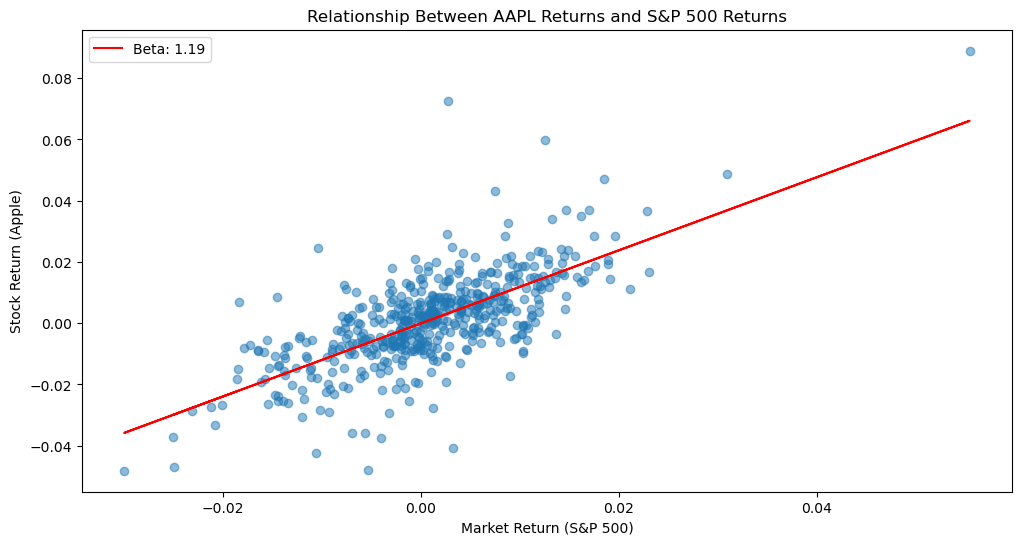

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the stock ticker for Apple
stock_ticker = "AAPL"

# Define the market index tickers (S&P 500 and VIX)
market_index_ticker = '^GSPC'
VIX = '^VIX'

# Define the period for historical data
period = '2y'
interval = '1d'

# Fetch data using yfinance for Apple and S&P 500 Index
stock_data = yf.download(stock_ticker, period = period, interval = interval)["Close"]
market_data = yf.download(market_index_ticker, period = period, interval = interval)["Close"]

# Drop missing data from both series
data = pd.concat([stock_data, market_data], axis = 1).dropna()
data.columns = ["Stock_Close", "Market_Close"]

# Calculate daily returns for stock and market
data["Stock_Return"] = data["Stock_Close"].pct_change()
data["Market_Return"] = data["Market_Close"].pct_change()

# Drop NaN values fromm returns 
data.dropna(inplace = True)

# Perform linear regression to calculate beta
X = data["Market_Return"].values.reshape(-1, 1)
y = data["Stock_Return"].values.reshape(-1, 1)

# Use linear regression to find beta
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X, y)

# Beta is the slope of the line
beta = reg.coef_[0][0]
print(f"Beta for {stock_ticker}: {beta}")

# Plot the market return vs stock return to visualize the relationship 
plt.figure(figsize = (12, 6))
plt.scatter (data["Market_Return"], data["Stock_Return"], alpha = 0.5)
plt.plot(data["Market_Return"], reg.predict(X), color = "red", label = f"Beta: {beta:.2f}")
plt.xlabel("Market Return (S&P 500)")
plt.ylabel("Stock Return (Apple)")
plt.title(f"Relationship Between {stock_ticker} Returns and S&P 500 Returns")
plt.legend()
plt.show()


Baidu price movement

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


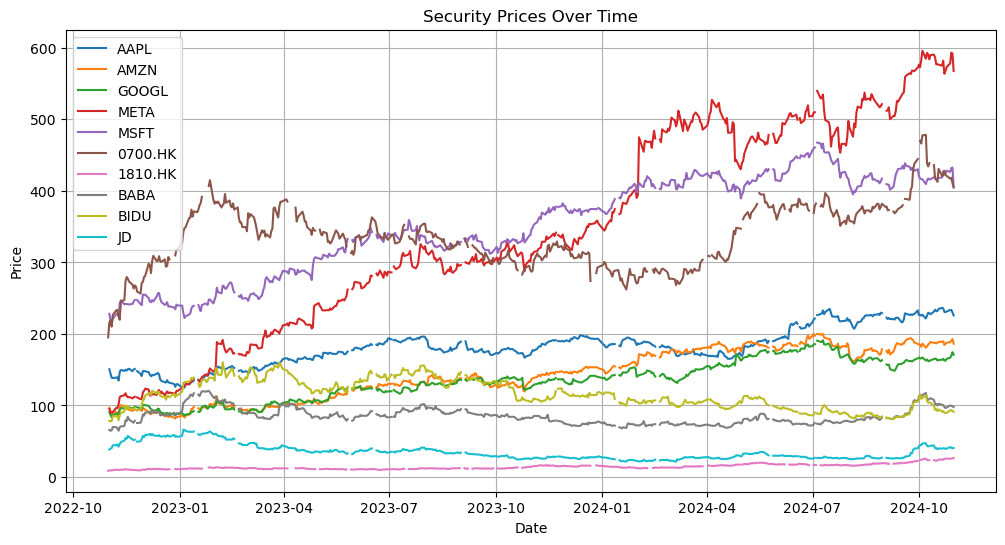

'\n# Keep only the closing prices and opening prices\nus_open = us_data[\'Open\']\nus_close = us_data[\'Close\']\nhk_close = hk_data[\'Close\'] * 8 / 7.8\nhk_open_next = hk_data[\'Open\'].shift(-1) * 8 / 7.8\n\n# Combine the data into a single DataFrame\ndf = pd.concat([us_open, hk_close, us_close, hk_open_next], axis = 1)\ndf.columns = [\'US_Open\', \'HK_Close\',\'US_Close\',\'HK_Open_next\']\n\n# Drop rows with missing data\ndf.dropna(inplace = True)\n\n# Calculate correlation between HK close and US open price\ncorrelation_1 = df[\'US_Open\'].corr(df[\'HK_Close\'])\ncorrelation_2 = df[\'US_Close\'].corr(df[\'HK_Close\'])\ncorrelation_3 = df[\'US_Close\'].corr(df[\'HK_Open_next\'])\nprint (f"Correlation between US Opening price and HK Closing price: {correlation_1}")\nprint (f"Correlation between US Closing price and HK Closing price: {correlation_2}")\nprint (f"Correlation between US Closing price and HK Open price next day: {correlation_3}")\n\n# Plot the closing and opening prices

In [79]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define stock tickers for Alibaba on different exchanges
us_ticker = 'GOOG'
hk_ticker = '9888.HK'

us_tech_stocks = ["AAPL", "GOOGL", "AMZN", "META","MSFT"]

# Define stock tickers for Chinese tech stocks
china_tech_stocks = ["JD", "BABA", "BIDU", "0700.HK", "1810.HK"]

# Define the period for historical data
period = '2y'   
#period = '3mo' 
interval = '1d'

# Fetch data using yfinance
us_data = yf.download(us_ticker, period = period, interval = interval)
hk_data = yf.download(hk_ticker, period = period, interval = interval)

us_tech_data = yf.download(us_tech_stocks, period = period, interval = interval)['Close']
china_tech_data = yf.download(china_tech_stocks, period = period, interval = interval)['Close']

tech_data = pd.concat([us_tech_data,china_tech_data], axis = 1)
plt.figure(figsize=(12, 6))
plt.plot(tech_data)
plt.title('Security Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(tech_data.columns)
plt.grid(True)
plt.show()
"""
# Keep only the closing prices and opening prices
us_open = us_data['Open']
us_close = us_data['Close']
hk_close = hk_data['Close'] * 8 / 7.8
hk_open_next = hk_data['Open'].shift(-1) * 8 / 7.8

# Combine the data into a single DataFrame
df = pd.concat([us_open, hk_close, us_close, hk_open_next], axis = 1)
df.columns = ['US_Open', 'HK_Close','US_Close','HK_Open_next']

# Drop rows with missing data
df.dropna(inplace = True)

# Calculate correlation between HK close and US open price
correlation_1 = df['US_Open'].corr(df['HK_Close'])
correlation_2 = df['US_Close'].corr(df['HK_Close'])
correlation_3 = df['US_Close'].corr(df['HK_Open_next'])
print (f"Correlation between US Opening price and HK Closing price: {correlation_1}")
print (f"Correlation between US Closing price and HK Closing price: {correlation_2}")
print (f"Correlation between US Closing price and HK Open price next day: {correlation_3}")

# Plot the closing and opening prices to visualize
plt.figure(figsize = (12, 6))
plt.plot(df.index, df['US_Close'],label = 'US Market Close (NYSE)', color='blue')
plt.plot(df.index, df['US_Open'], label = 'US Market Open (NYSE)', color = 'green')
plt.plot(df.index, df['HK_Close'], label = 'HK Market Close (HKEX)', color = 'red')
plt.plot(df.index, df['HK_Open_next'], label = 'HK Market Open Next Day', color = 'orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Baidu US Close Prices vs. US Open Prices vs. Hong Kong Close Prices')
plt.legend()
plt.show()"""

In [71]:
!pip install pandas_datareader


   ---------------------------------------- 0.0/109.5 kB ? eta -:--:--
   --- ------------------------------------ 10.2/109.5 kB ? eta -:--:--
   -------------- ------------------------ 41.0/109.5 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 109.5/109.5 kB 1.3 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Correlation between US Opening price and HK Closing price: 0.999540930023735
Correlation between US Closing price and HK Closing price: 0.9989023836996008
Correlation between US Closing price and HK Open price next day: 0.999714704338512


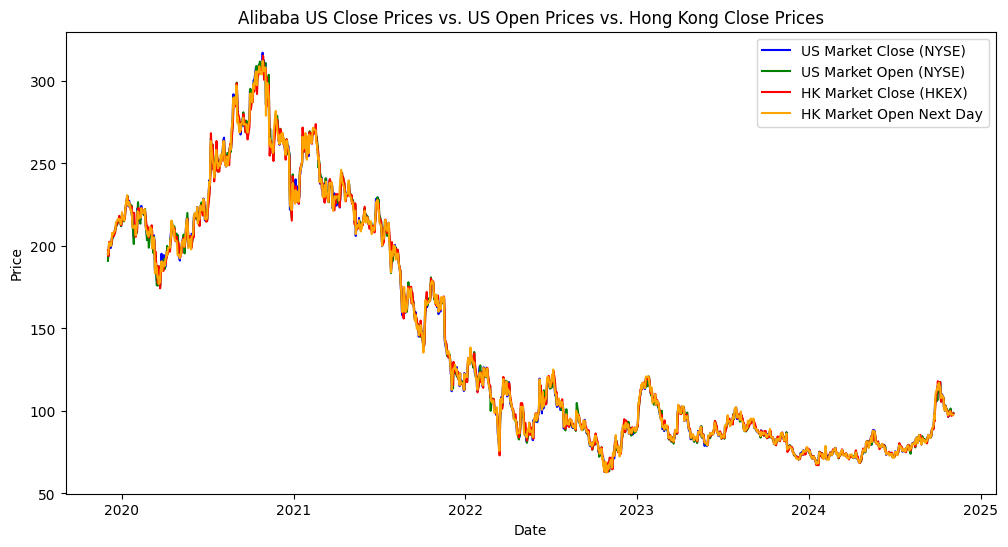

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Redefine stock tickers and date range
us_ticker = 'BABA'
hk_ticker = '9988.HK'
start_date = '2018-01-01'
end_date = '2023-01-01'
period = '5y'
interval = '1d'

# Fetch historical data again
us_data = yf.download(us_ticker, period=period, interval=interval)
hk_data = yf.download(hk_ticker, period=period, interval=interval)

# Additional features (VIX, SP500, HSI)
vix = yf.download('^VIX', start=start_date, end=end_date)['Close']
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close']
hsi = yf.download('^HSI', start=start_date, end=end_date)['Close']

# Combine the features into the DataFrame
df = pd.DataFrame(index=us_data.index)
df['US_Open'] = us_data['Open']
df['US_Close'] = us_data['Close']
df['HK_Close'] = hk_data['Close'] * 8 / 7.8
df['HK_Open_next'] = hk_data['Open'].shift(-1) * 8 / 7.8
df['VIX'] = vix
df['SP500'] = sp500
df['HSI'] = hsi

# Adding Volume Data for both US and HK
df['US_Volume'] = us_data['Volume']
df['HK_Volume'] = hk_data['Volume']

# Adding US 10-Year Treasury Yield and Forward Fill Missing Data
treasury_yield = yf.download('^TNX', start=start_date, end=end_date)['Close']
df['Treasury_Yield'] = treasury_yield

# Forward fill, then backward fill any remaining NaNs
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Adding Moving Averages (20-day) for both US and HK
df['US_MA20'] = df['US_Close'].rolling(window=20).mean()
df['HK_MA20'] = df['HK_Close'].rolling(window=20).mean()

# Adding Relative Strength Index (RSI) for US Close Prices
def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['RSI_US'] = calculate_rsi(df['US_Close'])

# Adding Price Ratio (US to HK Close Prices)
df['US_HK_Ratio'] = df['US_Close'] / df['HK_Close']

# Drop rows with remaining missing data
df.dropna(inplace=True)

# Correlation calculations
correlation_1 = df['US_Open'].corr(df['HK_Close'])
correlation_2 = df['US_Close'].corr(df['HK_Close'])
correlation_3 = df['US_Close'].corr(df['HK_Open_next'])
print(f"Correlation between US Opening price and HK Closing price: {correlation_1}")
print(f"Correlation between US Closing price and HK Closing price: {correlation_2}")
print(f"Correlation between US Closing price and HK Open price next day: {correlation_3}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['US_Close'], label='US Market Close (NYSE)', color='blue')
plt.plot(df.index, df['US_Open'], label='US Market Open (NYSE)', color='green')
plt.plot(df.index, df['HK_Close'], label='HK Market Close (HKEX)', color='red')
plt.plot(df.index, df['HK_Open_next'], label='HK Market Open Next Day', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Alibaba US Close Prices vs. US Open Prices vs. Hong Kong Close Prices')
plt.legend()
plt.show()



#